# 訓練情感模型
分析這篇文章中的李＋賢是否有ＡＭＬ風險＿將2-2處理好的300個字資料集進行訓練

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW   # ✅ 從 torch 來
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

## 情感分析模型

In [3]:
df = pd.read_csv('data/Sentiment_model_data/step2_2_output_train_data_300.csv')

In [4]:
df

,article_index,truncated_text,tag,name
0,0,ewater Associates)、AQR 資產管理公司、曼氏集團 (Man Group)...,0,張堯勇
1,0,索羅斯的量子基金，也打敗了股神巴菲特的價值投資。近年來台灣也逐漸重視量化交易，摩根亞太量化交...,0,張堯勇
2,0,如何選股是一門學問。目前全球 60 個主要股市交易所，總市值 70 兆美元，而台灣上市上櫃市...,0,張堯勇
3,0,中美貿易戰為例，台股上市、上櫃指數均是負報酬，不過，摩根量化交易卻是正報酬，而且波動度也比較...,0,張堯勇
4,0,不準發放現金股利、部分保險公司必須儘快舉辦現金增資、以後賣的保單利率必須下降。另外台灣全體商...,0,張堯勇
...,...,...,...,...
29837,4600,利益，不但難辭其咎、本末倒置，更是在助學店為虐！學校不是營利組織，大學亦非是職業訓練所，學位...,0,朱俊彰
29838,4602,17:50facebook commentFONT SIZEICON PRINT全球投資市...,0,黃維本
29839,4602,大操作秘訣，其中近遠月價差、期貨現貨套利價差以及 Tick trade，是今年上半年最賺錢的...,0,黃維本
29840,4602,期貨股票影/今年上半年 三大股票期貨交易策略最賺錢鉅亨網記者 李家賢、李佳泓2019/09/...,0,鄭心芸


In [5]:
df.tag.value_counts()
# 正負樣本差異

tag
0    27404
1     2438
Name: count, dtype: int64

In [6]:
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")#, do_lower_case=False)

In [7]:
sample_txt = df.iloc[0].truncated_text
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: ewater Associates)、AQR 資產管理公司、曼氏集團 (Man Group)、文藝復興科技 (Renaissance Technologies) 等全球知名避險基金。摩根亞太集團董事長李家賢指出，避險基金規模約為 5 兆美元，採取量化交易的基金規模約 1 兆美元，比重佔了 20%，代表量化交易的操作績效好，才會有那麼高的比重。量化交易的操作績效不亞於價值投資及技術投資，被譽為數學天才、最賺錢的基金經理人，文藝復興對沖基金創始人詹姆斯 · 西蒙斯 (James Simons) 所管理的大獎章 (Medallion) 基金，便是典型的量化交易，績效表現優異，不僅勝過索羅斯的量子基金，也打敗了股神巴菲特的價值投資。近年來台灣也逐漸重視量化交易，摩根亞太量化交易公
   Tokens: ['e', '##wa', '##ter', '[UNK]', ')', '、', '[UNK]', '資', '產', '管', '理', '公', '司', '、', '曼', '氏', '集', '團', '(', '[UNK]', '[UNK]', ')', '、', '文', '藝', '復', '興', '科', '技', '(', '[UNK]', '[UNK]', ')', '等', '全', '球', '知', '名', '避', '險', '基', '金', '。', '摩', '根', '亞', '太', '集', '團', '董', '事', '長', '李', '家', '賢', '指', '出', '，', '避', '險', '基', '金', '規', '模', '約', '為', '5', '兆', '美', '元', '，', '採', '取', '量', '化', '交', '易', '的', '基', '金', '規', '模', '約', '1', '兆', '美', '元', '，', '比', '重', '佔', '了', '20', '%', '，', '代', '表', '量', '化', '交', '易', '的', '操', '作', '績', '效', '好', '，', '才', '會', '有', '那', '麼', '高', '的', '比', '重', '。', '量', '化', '交',

In [14]:
df_train_val, df_test = train_test_split(
  df,
  test_size=0.1,
  random_state=38
)

In [15]:
df_train = df_train_val.iloc[:int(len(df_train)*0.9)]
df_val = df_train_val.iloc[int(len(df_train)*0.9):]

In [16]:
df_train.tag.value_counts()#0.08869431270014999

tag
0    19976
1     1777
Name: count, dtype: int64

In [17]:
df_test.tag.value_counts() #0.09140767824497258

tag
0    2735
1     250
Name: count, dtype: int64

In [18]:
df_val.tag.value_counts() #0.09140767824497258

tag
0    6705
1     575
Name: count, dtype: int64

In [19]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'targets': torch.tensor(target, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size, shuffle=False):
    ds = GPReviewDataset(
        reviews=df.truncated_text.to_numpy(),
        targets=df.tag.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=0
    )


In [20]:
MAX_LEN = 300
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [21]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-chinese")
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output  # 取出 pooler 的 [CLS] 向量
        output = self.drop(pooled_output)
        return self.out(output)

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
class_names = ['negative', 'positive']
model = SentimentClassifier(n_classes=len(class_names))
model = model.to(device)

In [24]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [25]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [26]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
%%time

history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'model/best_model_state.pth')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.11168264299054392 accuracy 0.9612926952604239
Val   loss 0.08430756828271155 accuracy 0.9690934065934066

Epoch 2/10
----------
Train loss 0.0643235739120401 accuracy 0.9805544062887879
Val   loss 0.06927575604807186 accuracy 0.9785714285714285

Epoch 3/10
----------
Train loss 0.03291991507964052 accuracy 0.9913575139061279
Val   loss 0.06850088101955706 accuracy 0.9837912087912087

Epoch 4/10
----------
Train loss 0.014986005630575339 accuracy 0.9965062290258816
Val   loss 0.06203477447539466 accuracy 0.9907967032967033

Epoch 5/10
----------


KeyboardInterrupt: 

In [ ]:
# # save model
# import os 
# PATH = os.getcwd()+str('/step3_output_bert_senti.pth')
# torch.save(model, PATH)

In [ ]:
# PATH = os.getcwd()+str('/step3_output_bert_senti.pth')

# model2 = torch.load(PATH)
# model2.eval()

In [30]:
history['train_acc']

[tensor(0.9613, device='cuda:0', dtype=torch.float64),
 tensor(0.9806, device='cuda:0', dtype=torch.float64),
 tensor(0.9914, device='cuda:0', dtype=torch.float64),
 tensor(0.9965, device='cuda:0', dtype=torch.float64)]

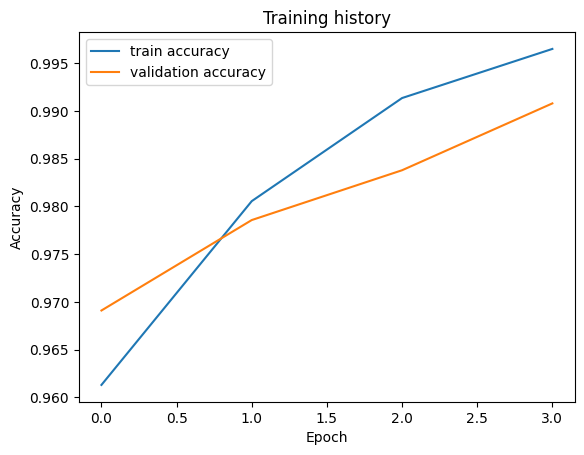

In [31]:
plt.plot([t.cpu().numpy() for t in history['train_acc']], label='train accuracy')
plt.plot([t.cpu().numpy() for t in history['val_acc']], label='validation accuracy')
plt.title('Training history')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [32]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
#test_acc.item()

In [33]:
test_acc.item() #0.9728643216080403

0.9912897822445561

In [34]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)
    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [35]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [36]:
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    negative       1.00      1.00      1.00      2735
    positive       0.95      0.95      0.95       250

    accuracy                           0.99      2985
   macro avg       0.97      0.97      0.97      2985
weighted avg       0.99      0.99      0.99      2985



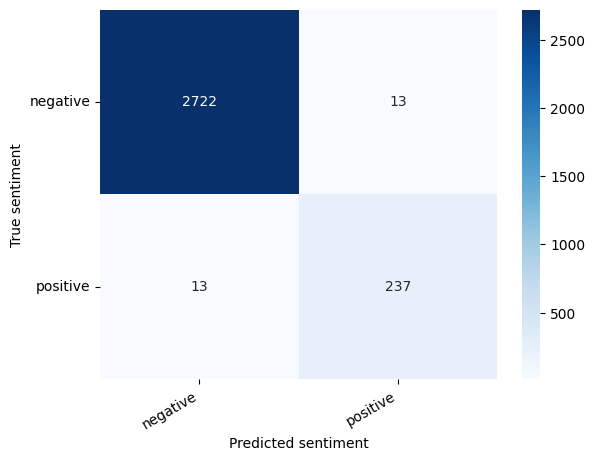

In [37]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [38]:
idx = 7
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

子以及嫂子為人頭，詐領每個月8萬元助理費用，共詐領429萬1235元。全案檢方偵結，認事證明確，依法起訴李家賢及李家賢的哥哥、兒子與嫂子等4
人。

True sentiment: positive


# 預測

In [49]:
class_names = ['negative', 'positive']

# 1. 定義模型
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-chinese")
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        pooled_output = outputs.pooler_output  # 取出 pooler 的 [CLS] 向量
        output = self.drop(pooled_output)
        return self.out(output)
PATH = 'model/best_model_state.pth'#'step3_output_bert_senti.pth'
       
model2 = SentimentClassifier(n_classes=len(class_names))
model2.load_state_dict(torch.load(PATH, map_location=device))

# 2. 放到 GPU/CPU
model2.to(device)
model2.eval()

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [50]:
review_text = "富二代網路警察李家賢查獲一間詐騙集團，協助玉山銀行進行洗錢防制"
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=100,#MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [51]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model2(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: 富二代網路警察李家賢查獲一間詐騙集團，協助玉山銀行進行洗錢防制
Sentiment  : positive
